In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
from scipy.fft import fft, fftfreq
from sklearn.metrics import r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_squared_error,
)
from sktime.transformations.series.detrend import Detrender
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings('ignore')

sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def plot_ts_pacf(series, item_id, pacf_lags=30):
    # визуализация ряда и ЧАКФ
    _, axes = plt.subplots(2, 1, figsize=(8, 6))

    columns = [
        column for column in series.columns if column in ('date', 'cnt', 'resid')
    ]

    axes[0].plot(series[columns[0]], series[columns[1]])
    axes[0].set_title(f'временной ряд продаж {item_id}')

    plot_pacf(series[columns[1]], lags=pacf_lags, ax=axes[1])
    axes[1].set_title('частичная автокорреляционная функция')

    plt.tight_layout()
    plt.show()


def kpss_test(series):
    # является ли ряд стационарным по критерию Квятковского-Филлипса-Шмидта-Шина
    p_value = kpss(series, regression='c', nlags='auto')[1]
    return p_value >= 0.05, p_value


def adf_test(series):
    # является ли ряд стационарным по критерию Дики-Фуллера
    p_value = adfuller(series, autolag='AIC')[1]
    return p_value < 0.05, p_value


def test_stat(row) -> tuple[bool, float, float]:
    # является ли ряд стационарным по обоим критериям
    is_stat_kpss, kpsstest = kpss_test(row)
    is_stat_adf, adftest = adf_test(row)

    return is_stat_kpss | is_stat_adf, kpsstest, adftest  # type: ignore


def metrics_report(y_true, y_pred) -> pd.DataFrame:
    # метрики качества прогноза
    y_true_mean = y_true.mean().values * np.ones(shape=(len(y_true),))

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mae_zero = mean_absolute_error(y_true_mean, y_pred)

    report = pd.DataFrame(
        [mse, r2, mae, mae_zero],
        index=['mse', 'r2', 'mae', 'mae_zero'],
    )
    return report


def fourier_extrapolation(x, n_predict, n_harm=20, inner_freq=1.0) -> np.ndarray:
    # экстраполяция рядов Фурье
    # https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
    n = x.size
    t = np.arange(0, n)

    x_freqdom = fft(x, axis=0)  # x in frequency domain
    f = fftfreq(n, inner_freq)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[: 1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # type: ignore # amplitude
        phase = np.angle(x_freqdom[i])  # type: ignore # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t * inner_freq + phase)

    return restored_sig

# данные по первому магазину


In [3]:
df = pd.read_csv('../data/shop_sales_all.csv')
df['date'] = pd.to_datetime(df['date'])

df_681 = df[df['item_id'] == 'STORE_1_546']  # рассмотрим определенный артикул
df_681.tail()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_1,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,cnt,sell_price
27217,2016-01-17,11551,Sunday,2,1,2016,1815,0,0,0,0,0,1,STORE_1_546,STORE_1,5,5.980
27239,2016-01-18,11551,Monday,3,1,2016,1816,0,0,1,0,0,0,STORE_1_546,STORE_1,3,5.980
27247,2016-01-19,11551,Tuesday,4,1,2016,1817,0,0,0,0,0,0,STORE_1_546,STORE_1,1,5.980
27269,2016-01-20,11551,Wednesday,5,1,2016,1818,0,0,0,0,0,0,STORE_1_546,STORE_1,2,5.980
27275,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0,STORE_1_546,STORE_1,2,5.980


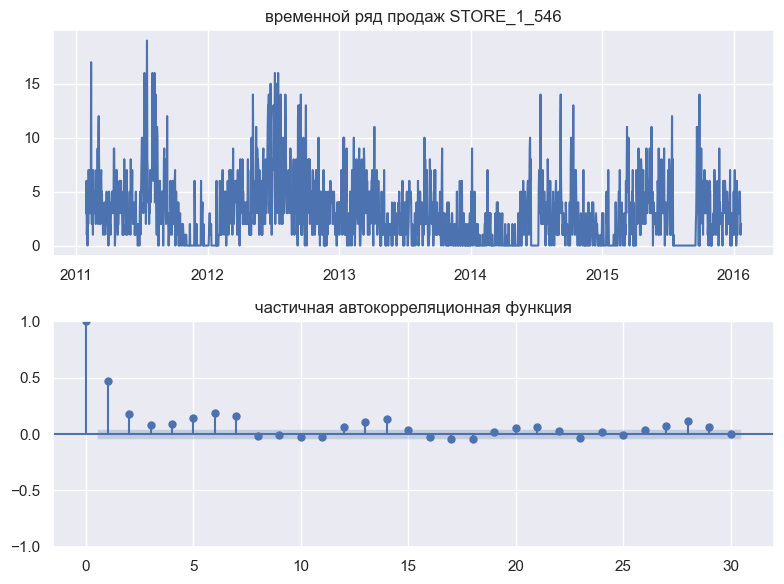

In [4]:
plot_ts_pacf(df_681, 'STORE_1_546', pacf_lags=30)

In [5]:
num_steps = 90
data = df_681[['date', 'cnt']].set_index('date')
data_train, data_test = data[:-num_steps], data[-num_steps:]

data_train.shape, data_test.shape  # размер выборок

((1729, 1), (90, 1))

# STL

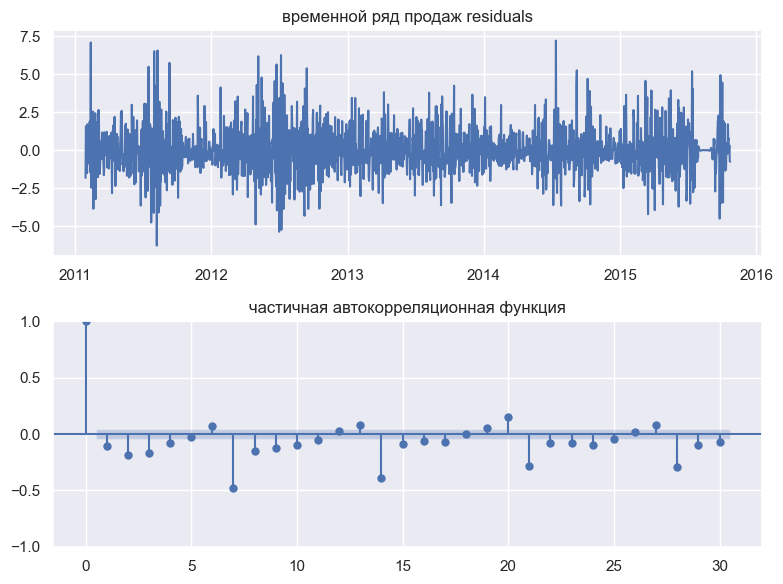

(True, 0.1, 4.7213158753105223e-29)


In [6]:
stl = STL(data_train, period=7)  # обучение модели STL
result = stl.fit()

plot_ts_pacf(result.resid.to_frame().reset_index(), 'residuals', pacf_lags=30)
# графики остатков

print(test_stat(result.resid))  # проверка на стационарность

критерии показали, что ряд остатков стационарный

In [7]:
print('KPSS:', kpss_test(data_train))
print('ADF:', adf_test(data_train))

KPSS: (False, 0.01)
ADF: (True, 0.0001501138331046137)


применение критериев KPSS и ADF может дать следующие результаты: 
    
1. оба теста говорят, что ряд нестационарный – ряд нестационарный

2. оба теста говорят, что ряд стационарный – ряд стационарный

3. KPSS говорит, что ряд стационарный, а ADF - что нестационарный, значит, у ряда
есть детерминированный тренд, который нужно убрать, чтобы получить стационарность

4. KPSS говорит, что ряд нестационарный, а ADF - что стационарный, значит, у ряда
есть стохастический тренд, который нужно убрать, чтобы получить стационарность

у ряда выше стохастический тренд

# SARIMA

In [8]:
fh = ForecastingHorizon(data_test.index, is_relative=False)

model = AutoARIMA(sp=7, seasonal=True, max_p=2, max_q=2, stationary=False)
model.fit(data_train)

y_pred = model.predict(data.index)
model.get_fitted_params()

d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

{'intercept': -6.2918368041670406e-06,
 'ar.L1': 0.06094244301231947,
 'ar.L2': 0.12754656407159132,
 'ma.L1': -0.8178319848815618,
 'ma.L2': -0.09411593738958979,
 'ar.S.L7': 0.9791801185848412,
 'ma.S.L7': -0.9194343454010065,
 'sigma2': 5.424732997510646,
 'order': (2, 1, 2),
 'seasonal_order': (1, 0, 1, 7),
 'aic': 7862.6626241686745,
 'aicc': 7862.746393802182,
 'bic': 7906.300383763586,
 'hqic': 7878.804182281209}

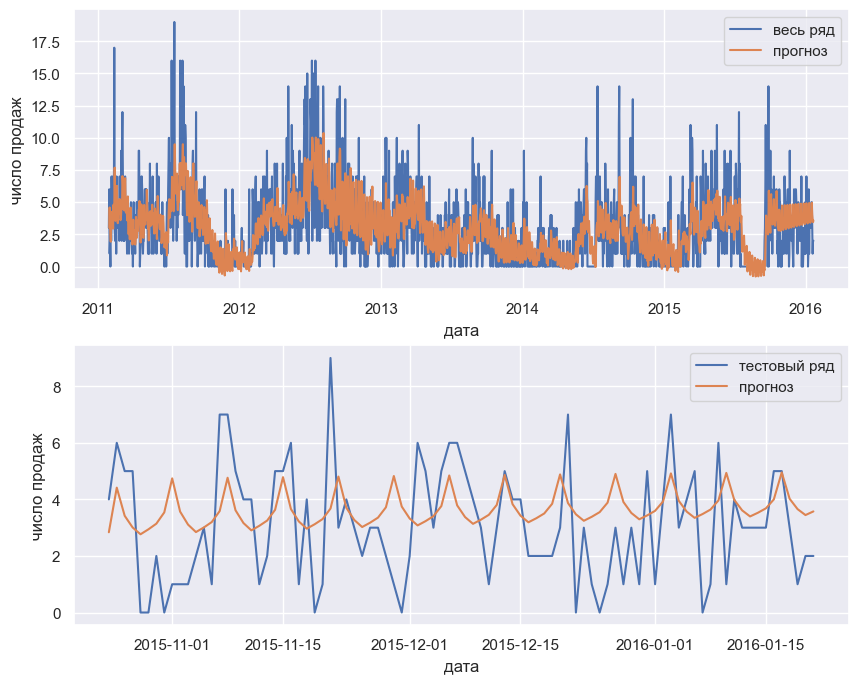

In [9]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(data, label='весь ряд')
plt.plot(y_pred, label='прогноз')  # type: ignore
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_test, label='тестовый ряд')
plt.plot(y_pred[-num_steps:], label='прогноз')  # type: ignore
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

In [10]:
arima_rep = metrics_report(data_test, y_pred[-num_steps:])  # type: ignore
arima_rep.columns = ['SARIMA']
arima_rep  # оценка качества модели

,SARIMA
mse,4.132
r2,-0.009
mae,1.689
mae_zero,0.597


# Fourier

In [11]:
forecaster = PolynomialTrendForecaster(degree=3)
forecaster.fit(data_train)  # выделяем из ряда полиномный тренд

data_train_detrend = Detrender(forecaster).fit_transform(data_train)
trend_pred = forecaster.predict(fh=np.arange(1, num_steps + 1))
trend = pd.concat([data_train - data_train_detrend, trend_pred])  # type: ignore

print('KPSS:', kpss_test(data_train_detrend))
print('ADF:', adf_test(data_train_detrend))
# проверка на стационарность

KPSS: (True, 0.1)
ADF: (True, 5.0015120443470296e-05)


In [12]:
pred_20 = fourier_extrapolation(  # n_harm = 20
    data_train_detrend, n_predict=num_steps, n_harm=20, inner_freq=1.0
)
pred_20 = pd.DataFrame(pred_20, index=data.index)
pred_20.columns = trend_pred.columns  # type: ignore
pred_20 = pred_20 + trend


pred_250 = fourier_extrapolation(  # n_harm = 250
    data_train_detrend, n_predict=num_steps, n_harm=250, inner_freq=1.0
)
pred_250 = pd.DataFrame(pred_250, index=data.index)
pred_250.columns = trend_pred.columns  # type: ignore
pred_250 = pred_250 + trend


pred_500 = fourier_extrapolation(  # n_harm = 500
    data_train_detrend, n_predict=num_steps, n_harm=500, inner_freq=1.0
)
pred_500 = pd.DataFrame(pred_500, index=data.index)
pred_500.columns = trend_pred.columns  # type: ignore
pred_500 = pred_500 + trend

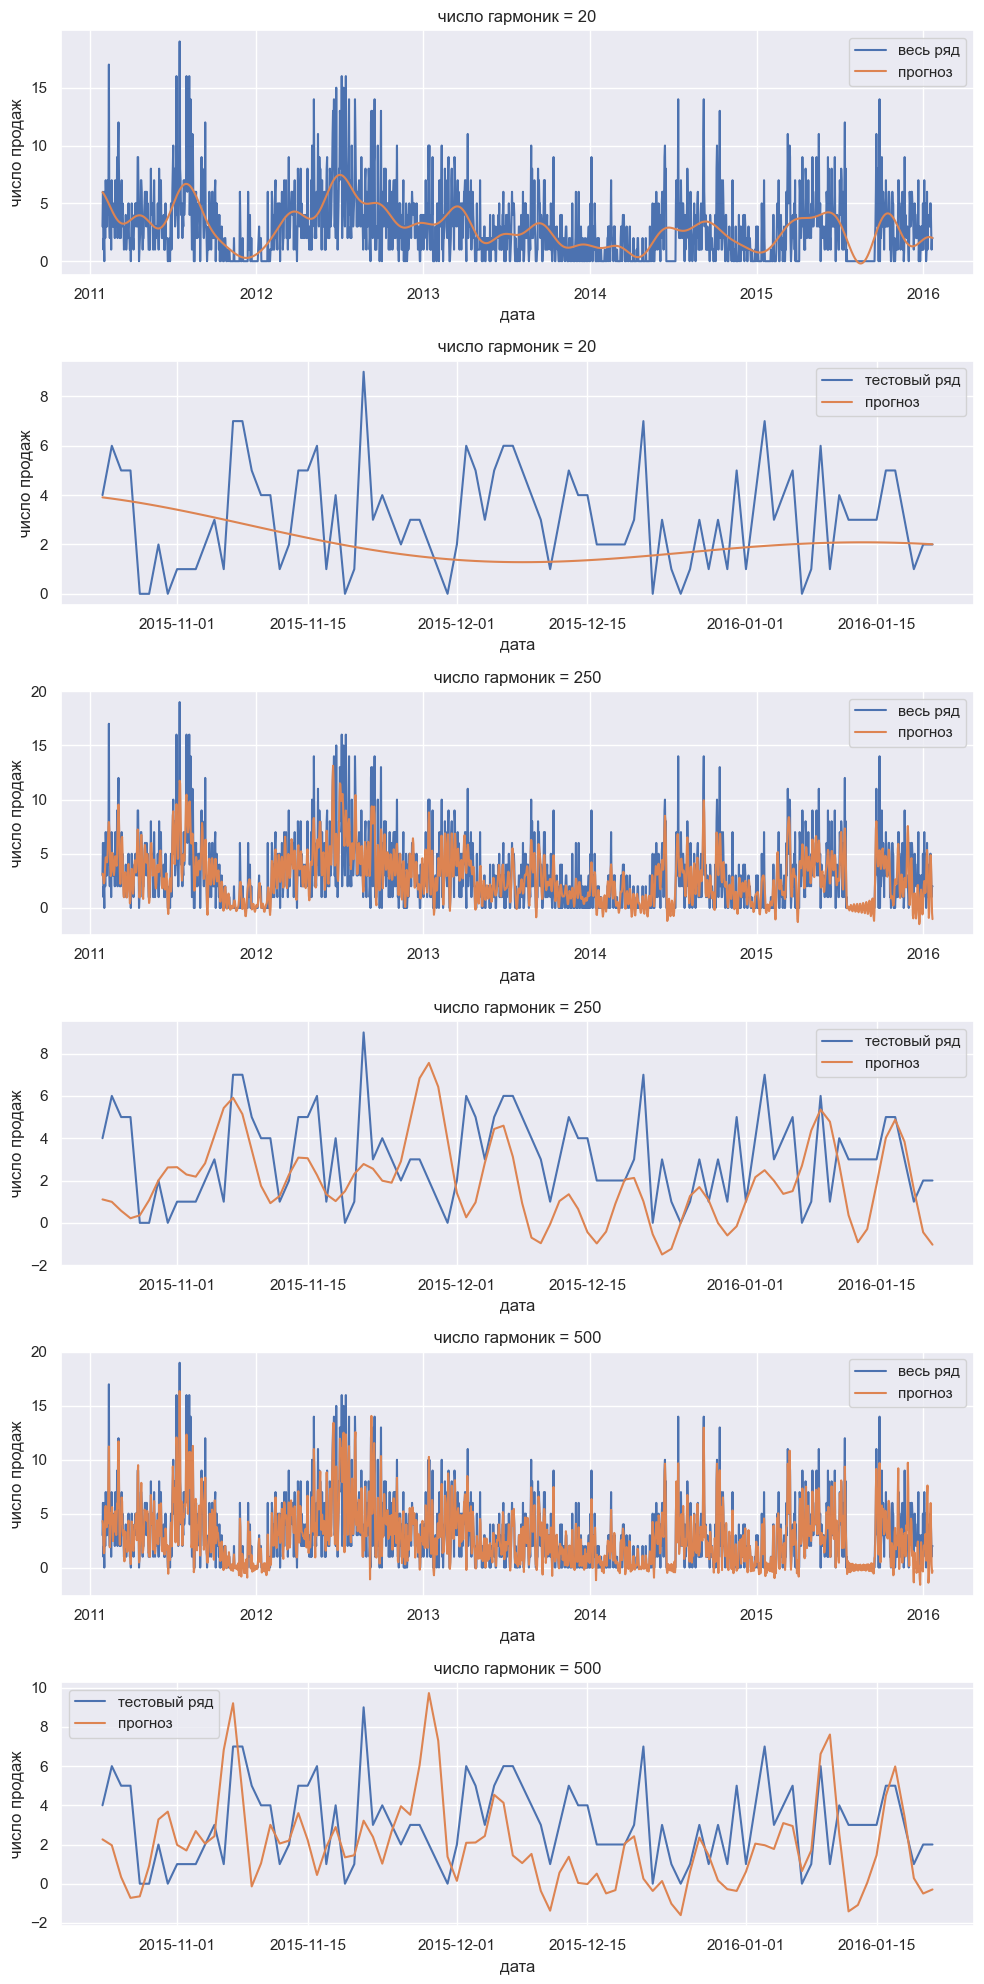

In [13]:
# Визуализация результатов
plt.figure(figsize=(10, 20))

plt.subplot(6, 1, 1)
plt.plot(data, label='весь ряд')
plt.plot(pred_20, label='прогноз')
plt.title('число гармоник = 20')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(data_test, label='тестовый ряд')
plt.plot(pred_20[-num_steps:], label='прогноз')
plt.title('число гармоник = 20')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(data, label='весь ряд')
plt.plot(pred_250, label='прогноз')
plt.title('число гармоник = 250')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(data_test, label='тестовый ряд')
plt.plot(pred_250[-num_steps:], label='прогноз')
plt.title('число гармоник = 250')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(data, label='весь ряд')
plt.plot(pred_500, label='прогноз')
plt.title('число гармоник = 500')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(data_test, label='тестовый ряд')
plt.plot(pred_500[-num_steps:], label='прогноз')
plt.title('число гармоник = 500')
plt.xlabel('дата')
plt.ylabel('число продаж')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
fourier_rep = metrics_report(data_test, pred_500[-num_steps:])
fourier_rep.columns = ['Fourier']
fourier_rep

,Fourier
mse,8.641
r2,-1.111
mae,2.305
mae_zero,2.097


# Prophet

In [15]:
# учтем праздники
calendar_data = pd.read_csv('../data/shop_sales_dates.csv')
calendar_data['date'] = pd.to_datetime(calendar_data['date'])

calendar_data['event'] = calendar_data['event_name_1'].combine_first(
    calendar_data['event_name_2']
)

holidays_data = calendar_data.dropna(subset=['event'])
holidays = holidays_data[['date', 'event']]
holidays = holidays.rename(columns={'date': 'ds', 'event': 'holiday'})
holidays.tail()

,ds,holiday
1780,2015-12-14,Chanukah End
1791,2015-12-25,Christmas
1798,2016-01-01,NewYear
1804,2016-01-07,OrthodoxChristmas
1815,2016-01-18,MartinLutherKingDay


In [16]:
df_prophet = df_681.reset_index(drop=True).rename(columns={'date': 'ds', 'cnt': 'y'})

data_train = df_prophet.iloc[:-num_steps]
data_test = df_prophet.iloc[-num_steps:]
data_train.tail()

,ds,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_1,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,y,sell_price
1724,2015-10-19,11538,Monday,3,10,2015,1725,0,0,0,0,0,0,STORE_1_546,STORE_1,5,5.980
1725,2015-10-20,11538,Tuesday,4,10,2015,1726,0,0,0,0,0,0,STORE_1_546,STORE_1,1,5.980
1726,2015-10-21,11538,Wednesday,5,10,2015,1727,0,0,0,0,0,0,STORE_1_546,STORE_1,2,5.980
1727,2015-10-22,11538,Thursday,6,10,2015,1728,0,0,0,0,0,0,STORE_1_546,STORE_1,0,5.980
1728,2015-10-23,11538,Friday,7,10,2015,1729,0,0,0,0,0,0,STORE_1_546,STORE_1,1,5.980


In [17]:
model = Prophet(holidays=holidays)

model.add_regressor('CASHBACK_STORE_1')
model.add_regressor('type_Cultural')
model.add_regressor('type_National')
model.add_regressor('type_Religious')
model.add_regressor('type_Sporting')

model.fit(data_train)

future = model.make_future_dataframe(periods=num_steps)

23:45:11 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
forecast = model.predict(df_prophet)
test_forecast = forecast.iloc[-num_steps:]
test_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CASHBACK_STORE_1,CASHBACK_STORE_1_lower,CASHBACK_STORE_1_upper,Chanukah End,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1814,2016-01-17,2.097,-1.072,5.619,2.056,2.137,0.000,0.000,0.000,0.000,...,1.641,1.641,1.641,-1.422,-1.422,-1.422,0.000,0.000,0.000,2.315
1815,2016-01-18,2.097,-0.914,5.429,2.056,2.138,0.000,0.000,0.000,0.000,...,0.312,0.312,0.312,-1.470,-1.470,-1.470,0.000,0.000,0.000,2.342
1816,2016-01-19,2.098,-2.848,3.266,2.055,2.139,0.000,0.000,0.000,0.000,...,-0.348,-0.348,-0.348,-1.512,-1.512,-1.512,0.000,0.000,0.000,0.238
1817,2016-01-20,2.099,-3.309,3.223,2.055,2.141,0.000,0.000,0.000,0.000,...,-0.656,-0.656,-0.656,-1.547,-1.547,-1.547,0.000,0.000,0.000,-0.105
1818,2016-01-21,2.099,-3.450,2.923,2.054,2.142,0.000,0.000,0.000,0.000,...,-0.826,-0.826,-0.826,-1.574,-1.574,-1.574,0.000,0.000,0.000,-0.301


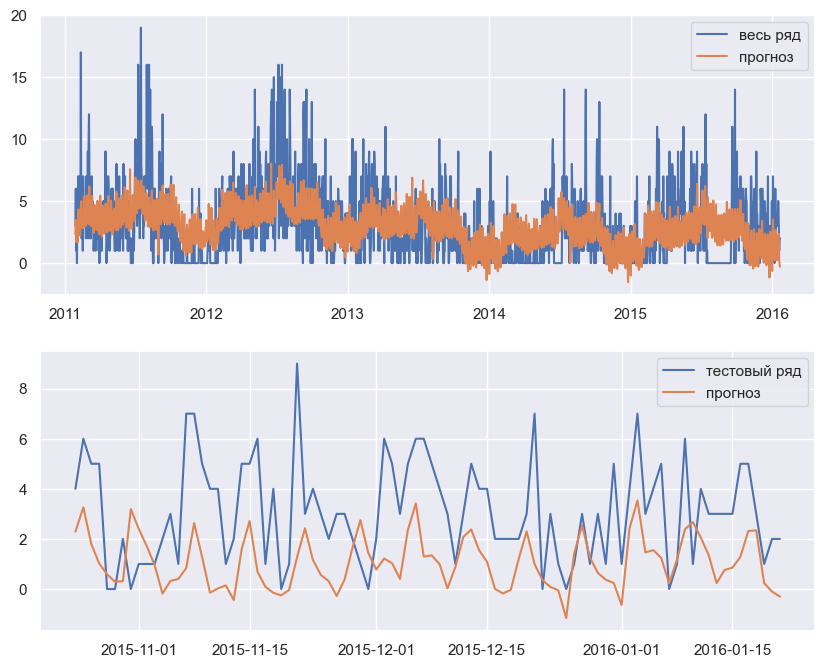

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(df_prophet.set_index('ds').y, label='весь ряд')
plt.plot(forecast.set_index('ds').yhat, label='прогноз')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_test.set_index('ds').y, label='тестовый ряд')
plt.plot(test_forecast.set_index('ds').yhat, label='прогноз')

plt.legend()

In [20]:
prophet_rep = metrics_report(
    data_test.set_index('ds')[['y']], test_forecast.set_index('ds')[['yhat']]
)
prophet_rep.columns = ['Prophet']
prophet_rep

,Prophet
mse,7.519
r2,-0.837
mae,2.278
mae_zero,2.025


# метрики в итоге

In [21]:
report = pd.concat([arima_rep, fourier_rep, prophet_rep], axis=1)
report

,SARIMA,Fourier,Prophet
mse,4.132,8.641,7.519
r2,-0.009,-1.111,-0.837
mae,1.689,2.305,2.278
mae_zero,0.597,2.097,2.025
